# 1) Install and import dependencies:

In [1]:
# ! pip install tensorflow-io==0.27.0
# ! pip install tensorflow==2.10.0

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
import os
import tensorflow as tf
import  tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby

In [4]:
 tf.__version__

'2.10.0'

# 2) Build a data loading function:

In [16]:
# define path to a single file of positive and negative example for testing:

CAPUCHIN_BIRD = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips/XC114131-0.wav"
NON_CAPUCHIN_BIRD = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav"

In [6]:
CAPUCHIN_BIRD

'/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips/XC114131-0.wav'

In [7]:
NON_CAPUCHIN_BIRD

'/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'

In [9]:
# decoding the wav audio files:


# 1) load the encoded wav audio file using io.read_file
audio_file = tf.io.read_file(CAPUCHIN_BIRD)

# 2) decode the encoded file: convert audio file to a tensor
wav, sample_rate = tf.audio.decode_wav(audio_file, desired_channels=1)

# 3) remove trailing axis
wav2 = tf.squeeze(wav, axis = -1)
sample_rate2 = tf.cast(sample_rate, dtype = tf.int64)

# 4) convert amplitude to 16000 hz
wav3 = tfio.audio.resample(wav2, rate_in = sample_rate2, rate_out = 16000)

In [10]:
sample_rate, sample_rate2

(<tf.Tensor: shape=(), dtype=int32, numpy=48000>,
 <tf.Tensor: shape=(), dtype=int64, numpy=48000>)

In [17]:
def load_wav_16k_mono(filename):
  # 1) load the encoded wav audio file using io.read_file
  audio_file = tf.io.read_file(filename)

  # 2) decode the encoded file: convert audio file to a tensor
  wav, sample_rate = tf.audio.decode_wav(audio_file, desired_channels=1)

  # 3) remove trailing axis
  wav2 = tf.squeeze(wav, axis = -1)
  sample_rate2 = tf.cast(sample_rate, dtype = tf.int64)

  # 4) convert amplitude to 16000 hz
  wav3 = tfio.audio.resample(wav2, rate_in = sample_rate2, rate_out = 16000)

  return wav3


capuchin_wav = load_wav_16k_mono(CAPUCHIN_BIRD)
non_capuchin_wav = load_wav_16k_mono(NON_CAPUCHIN_BIRD)

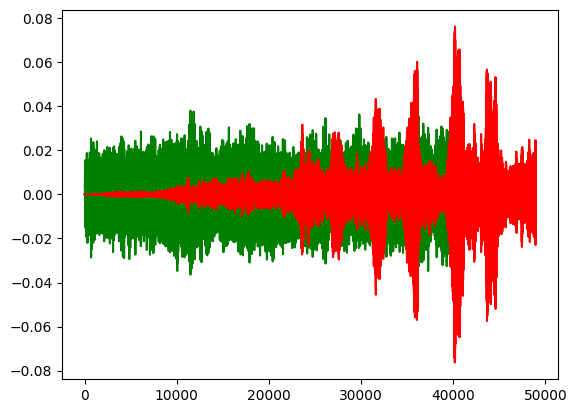

In [20]:
# plot graph for capuchin and non-capuchin wav files:

plt.plot(capuchin_wav, "g")
plt.plot(non_capuchin_wav, "r")
plt.show()

# 3) Create a tensorflow dataset:

In [25]:
capuchin_list = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips/*.wav"
    )
non_capuchin_list = tf.data.Dataset.list_files(
    "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Not_Capuchinbird_Clips/*.wav"
    )

In [26]:
capuchin_list, non_capuchin_list

(<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>)

In [34]:
len(capuchin_list), len(non_capuchin_list)

(217, 593)

In [37]:
positives = tf.data.Dataset.zip((capuchin_list, tf.data.Dataset.from_tensor_slices(tf.ones(len(capuchin_list)))))
negatives = tf.data.Dataset.zip((non_capuchin_list, tf.data.Dataset.from_tensor_slices(tf.zeros(len(non_capuchin_list)))))

data = positives.concatenate(negatives)

In [38]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [62]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips/XC513083-1.wav',
 1.0)

 # 4) Determine the average length of a Capuchin call:

In [48]:
lengths = []

capuchin_dir = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips"

for file in os.listdir(capuchin_dir):
  tensor_wav = load_wav_16k_mono(os.path.join(capuchin_dir,file))
  lengths.append(len(tensor_wav))


lengths[:5]

[48000, 40000, 56000, 48000, 64000]

In [57]:
# mean, median, min, max call length

print(tf.math.reduce_mean(lengths)) # 54156/16000 ~ 3.38 secs approx each capuchin call
print(np.median(lengths))
print(tf.math.reduce_min(lengths)) # aprrox 2 secs
print(tf.math.reduce_max(lengths)) # approx 5 secs


print("average call time in secs: ", tf.math.reduce_mean(lengths)/16000)

tf.Tensor(54156, shape=(), dtype=int32)
56000.0
tf.Tensor(32000, shape=(), dtype=int32)
tf.Tensor(80000, shape=(), dtype=int32)
average call time in secs:  tf.Tensor(3.38475, shape=(), dtype=float64)


In [56]:
np.median(lengths)

56000.0

# 5) Convert data into a spectogram:

In [65]:
wav = load_wav_16k_mono(CAPUCHIN_BIRD)
wav, len(wav)

(<tf.Tensor: shape=(40000,), dtype=float32, numpy=
 array([-2.1452930e-08,  2.9903514e-08,  2.3691292e-08, ...,
         1.1810826e-02,  1.3428938e-02,  3.8246573e-03], dtype=float32)>,
 40000)

In [67]:
tf.zeros(48000)

<tf.Tensor: shape=(48000,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [73]:
zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)

In [76]:
wav = tf.concat([zero_padding, wav], axis = 0)

In [83]:
spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
spectogram = tf.abs(spectogram)
spectogram = tf.expand_dims(spectogram, axis = 2)
# spectogram[:3]

In [89]:
def preprocess(file,  label):
  wav = load_wav_16k_mono(file)
  wav = wav[:48000]

  # for files with less than 48000 data points, we will pad with 0
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
  wav = tf.concat([zero_padding, wav], axis = 0)

  # use short time fourieer transform to convertt wav to spectogra
  spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
  spectogram = tf.abs(spectogram)
  spectogram = tf.expand_dims(spectogram, axis = 2) # make 3 dim
  return spectogram, label

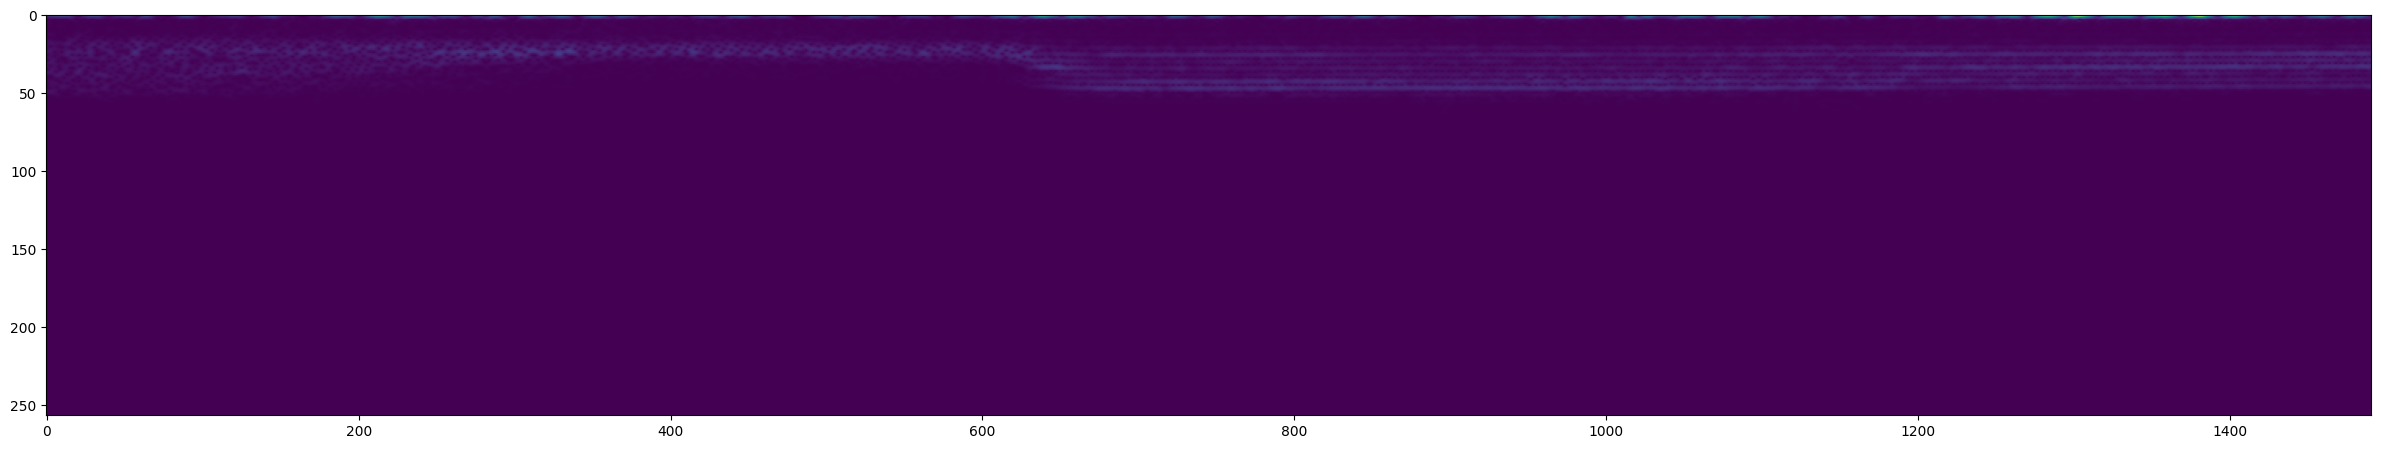

In [90]:
# positive sample spectogram:

file_path, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectogram, label = preprocess(file_path, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0]) #graph will be vertical without transponse
plt.show()

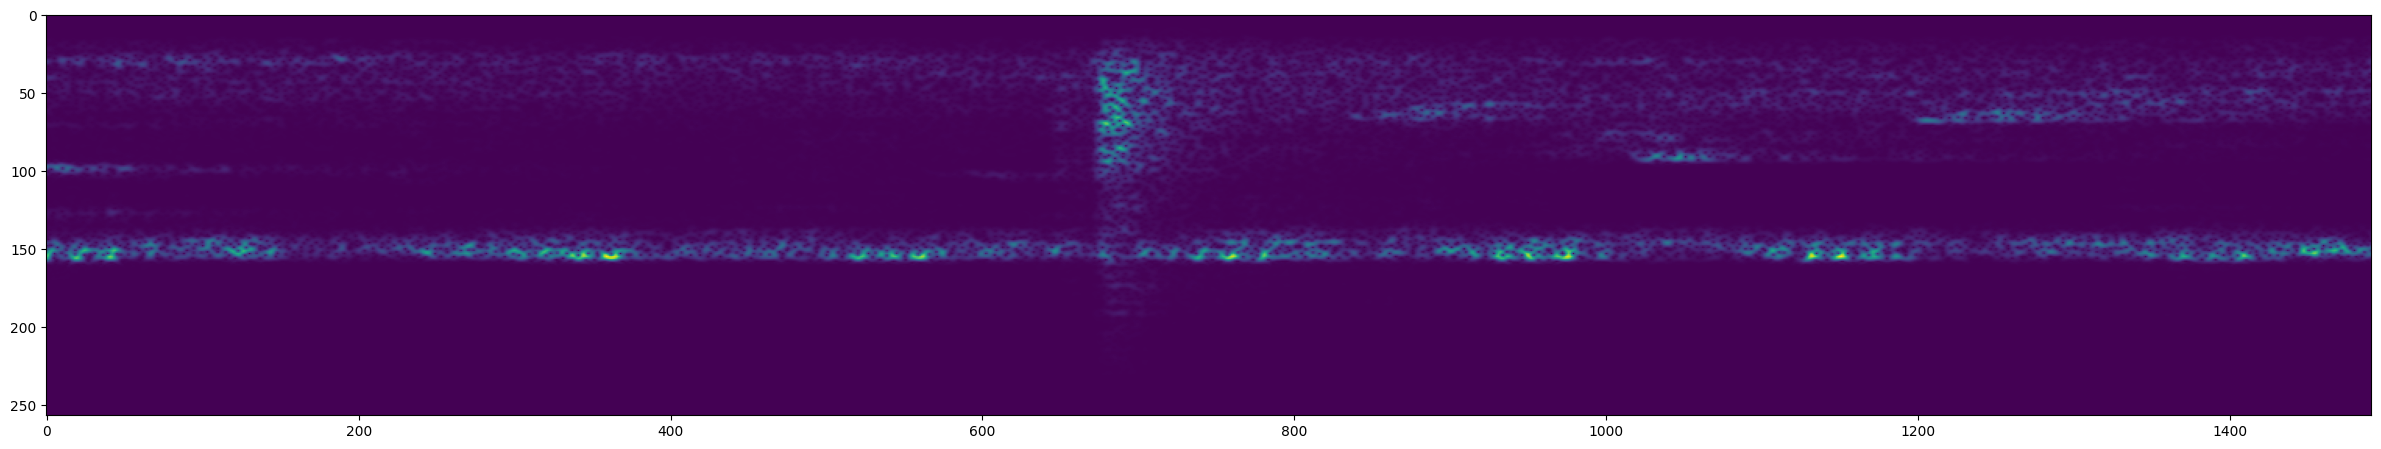

In [91]:
# negative sample spectogram:

file_path, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectogram, label = preprocess(file_path, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0]) #graph will be vertical without transponse
plt.show()

In [102]:
spectogram.shape

TensorShape([1491, 257, 1])

# 6) Train and Test spit:

In [92]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Parsed_Capuchinbird_Clips/XC27882-1.wav',
 1.0)

In [93]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 10000)
data = data.batch(16)
data = data.prefetch(8)

In [95]:
len(data), len(data)*0.8

(51, 40.800000000000004)

In [96]:
train = data.take(40)
test = data.skip(40).take(10)

In [98]:
train

<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# 7) Build DL model:

In [97]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [105]:
spectogram.shape

TensorShape([1491, 257, 1])

In [99]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu", input_shape = (1491,257,1)))
model.add(MaxPool2D(3,3))
model.add(Conv2D(16, (3,3), activation = "relu"))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile("Adam", loss = "BinaryCrossentropy", metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 496, 85, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 83, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 656032)            0         
                                                                 
 dense (Dense)               (None, 128)               83972224  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [115]:
hist = model.fit(train, epochs = 10, validation_data = test)

Epoch 1/10
40/40 [==============================] - 204s 5s/step - loss: 0.0031 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0026 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/10
40/40 [==============================] - 182s 5s/step - loss: 0.0014 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0018 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/10
40/40 [==============================] - 181s 5s/step - loss: 2.8092e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0238 - val_recall: 0.9783 - val_precision: 1.0000
Epoch 4/10
40/40 [==============================] - 185s 5s/step - loss: 0.0013 - recall: 0.9943 - precision: 1.0000 - val_loss: 0.0125 - val_recall: 1.0000 - val_precision: 0.9804
Epoch 5/10
40/40 [==============================] - 183s 5s/step - loss: 0.0055 - recall: 0.9939 - precision: 1.0000 - val_loss: 0.0019 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 6/10
40/40 [==============================] - 196s 5s/step - loss: 0.0033 - recall: 1

In [116]:
hist.history

{'loss': [0.0031270559411495924,
  0.001371615333482623,
  0.00028092297725379467,
  0.0013262315187603235,
  0.005543634295463562,
  0.0032939366064965725,
  0.002479684306308627,
  6.845231109764427e-05,
  3.7230780435493216e-05,
  3.092658153036609e-05],
 'recall': [1.0,
  1.0,
  1.0,
  0.9942857027053833,
  0.9939393997192383,
  1.0,
  0.994413435459137,
  1.0,
  1.0,
  1.0],
 'precision': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.0026016798801720142,
  0.0018354222411289811,
  0.023831617087125778,
  0.012517097406089306,
  0.001905045472085476,
  5.395876087277429e-06,
  6.69872752041556e-05,
  1.9876611986546777e-05,
  7.88234465289861e-05,
  1.5809295291546732e-05],
 'val_recall': [1.0, 1.0, 0.97826087474823, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_precision': [1.0,
  1.0,
  1.0,
  0.9803921580314636,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0]}

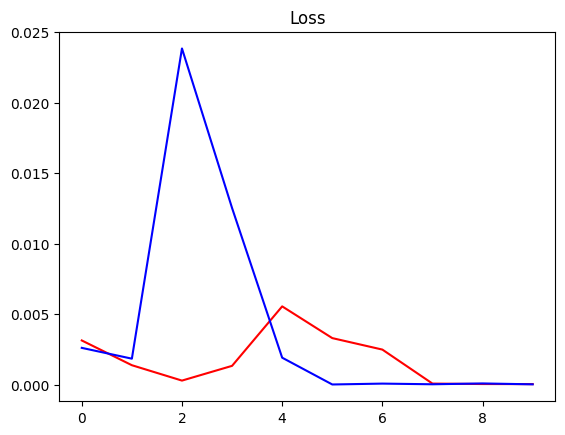

In [118]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

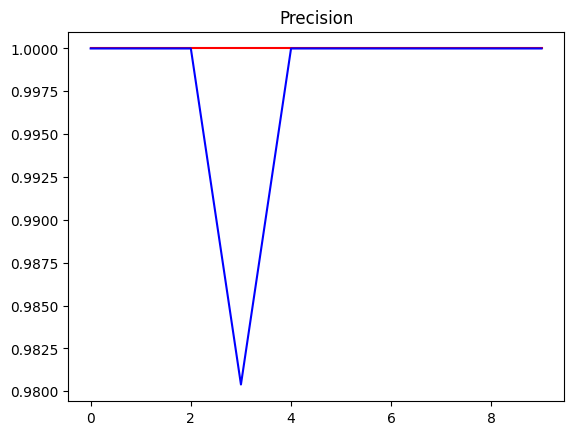

In [119]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

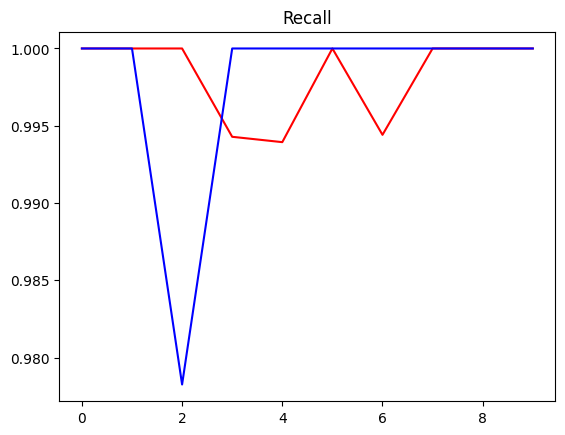

In [120]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8) Prediction on a single clip:

In [121]:
# prediction on one batch:
X_test, y_test = test.as_numpy_iterator().next()
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [122]:
y_pred2 = [1 if prediction >0 else 0 for prediction in y_pred]
tf.math.reduce_sum(y_pred2), tf.math.reduce_sum(y_test)

(<tf.Tensor: shape=(), dtype=int32, numpy=13>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.0>)

# 9) Load up forest recording mp3 audio files:

In [123]:
def load_mp3_16k_mono(filename):
  # 1) load the mp3 file using AudioIOTensor|
  res = tfio.audio.AudioIOTensor(filename)

  # 2) convert to tensor and combine 2 channels to one by avg it
  tensor = res.to_tensor()
  tensor  = tf.math.reduce_sum(tensor, axis = 1)/2

  # 3) extract sample rate and cast dtype
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  # 4) convert amplitude to 16000 hz
  wav3 = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)

  return wav3

In [124]:
mp3 = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Forest Recordings/recording_00.mp3"
wav = load_mp3_16k_mono(mp3)
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [125]:
# slice longer recording into audio slices size our model was trained on:

audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav,
    wav,
    sequence_length=48000,
    sequence_stride=48000, # 48000
    batch_size=1)

In [126]:
# 60 audio slices of len 48000 each
samples, index = audio_slices.as_numpy_iterator().next()

len(audio_slices), samples.shape

(60, (1, 48000))

In [128]:
samples[0]

array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
        6.2619494e-03, -1.5455363e-02, -8.7941047e-03], dtype=float32)

In [129]:
# convert mp3 files to spectograms:
# build a function to convert clips into windowed spectogram:

def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectogram = tf.abs(spectogram)
    spectogram = tf.expand_dims(spectogram, axis=2)
    return spectogram


In [130]:
# slice mp3 into  into windows and convert to windowed spectograms:

mp3 = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Forest Recordings/recording_00.mp3"
wav = load_mp3_16k_mono(mp3)

audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav,
    wav,
    sequence_length=48000,
    sequence_stride=48000, # 48000
    batch_size=1)

audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [131]:
# make predictions:

yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]
yhat

1/1 [==============================] - 7s 7s/step


[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [132]:
len(yhat), tf.math.reduce_sum(yhat)

(60, <tf.Tensor: shape=(), dtype=int32, numpy=9>)

In [139]:
# the model predicts consecutive instances of bird audio as separate predictions
# this is why we end up with a higher number of predictions
# to correct this, we will group consecutive predictions of same class together using iter

from itertools import groupby

yhat = [key for key, group in groupby(yhat)]
print(yhat)
calls = tf.math.reduce_sum(yhat).numpy()
print("==========")
print(calls)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
5


In [137]:
[key for key, group in groupby(yhat)]

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [138]:
for key, group in groupby(yhat):
  print(key, ": ", group)

0 :  <itertools._grouper object at 0x79dce02bceb0>
1 :  <itertools._grouper object at 0x79dce02bc3a0>
0 :  <itertools._grouper object at 0x79dce02bd960>
1 :  <itertools._grouper object at 0x79dcd8c80fd0>
0 :  <itertools._grouper object at 0x79dcd8c80160>
1 :  <itertools._grouper object at 0x79dcd8c83820>
0 :  <itertools._grouper object at 0x79dcd8c83370>
1 :  <itertools._grouper object at 0x79dce02bca30>
0 :  <itertools._grouper object at 0x79dce02bf160>
1 :  <itertools._grouper object at 0x79dcd8c81ba0>
0 :  <itertools._grouper object at 0x79dcd8c832b0>


# 10) Make predictions on entire forest recording dataset:

In [141]:
results = {}
forest_dir = "/content/drive/MyDrive/DeepLearning/DLP2_AudioClassification/data/Forest Recordings"

for file in os.listdir(forest_dir):
  FILE_PATH = os.path.join(forest_dir, file)

  wav = load_mp3_16k_mono(FILE_PATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(
    wav,
    wav,
    sequence_length=48000,
    sequence_stride=48000, # 48000
    batch_size=1)

  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  y_pred = model.predict(audio_slices)

  results[file] = y_pred


1/1 [==============================] - 7s 7s/step


In [142]:
# CONVERT PREDICTIONS TO CLASSES:
class_preds = {}
for file, preds in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in preds]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [143]:
# GROUP CONSECUTIVE DECISIONS:

postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 19,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 13,
 'recording_18.mp3': 4,
 'recording_19.mp3': 4,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_25.mp3': 13,
 'recording_24.mp3': 0,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_29.mp3': 0,
 'recording_28.mp3': 14,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_34.mp3': 4,
 'recording_37.mp3': 4,
 'recording_38.mp3': 13,
 'recording_36.mp3': 0,
 'recording_40.mp3': 1,
 'recording_39.mp3': 5,
 'recording

In [ ]:
# # EXPORT RESULTS AS CSV

# import csv
# with open('/content/drive/MyDrive/DeepLearning/DLP1_AudioClassification/results.csv', 'w', newline='') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(['recording', 'capuchin_calls'])
#     for key, value in postprocessed.items():
#         writer.writerow([key, value])